***
## Using Python's geo packages
***

In [20]:
import os
if False:
    os.system('python -m pip install wheel')
    os.system('python -m pip install c:/Users/Felipe/Desktop/GDAL-3.4.3-cp310-cp310-win_amd64.whl')
from osgeo import gdal

In [7]:
import matplotlib.pyplot as plt

In [8]:
import pandas as pd

In [9]:
import geopandas

### Creating a GeoDataFrame from a DataFrame with coordinates
---------------------------------------------------------

This example shows how to create a ``GeoDataFrame`` when starting from
a *regular* ``DataFrame`` that has coordinates either WKT
(`well-known text <https://en.wikipedia.org/wiki/Well-known_text>`_)
format, or in
two columns.

 ### From longitudes and latitudes
 =============================

 First, let's consider a ``DataFrame`` containing cities and their respective
 longitudes and latitudes.

In [10]:
df = pd.DataFrame(
    {'City': ['Buenos Aires', 'Brasilia', 'Santiago', 'Bogota', 'Caracas'],
     'Country': ['Argentina', 'Brazil', 'Chile', 'Colombia', 'Venezuela'],
     'Latitude': [-34.58, -15.78, -33.45, 4.60, 10.48],
     'Longitude': [-58.66, -47.91, -70.66, -74.08, -66.86]})

A GeoDataFrame needs a "shapely" object. 
We use geopandas ``points_from_xy()`` to transform **Longitude** and **Latitude** into a list
of ``shapely.Point`` objects and set it as a geometry while creating the
GeoDataFrame. (note that ``points_from_xy()`` is an enhanced wrapper for
``[Point(x, y) for x, y in zip(df.Longitude, df.Latitude)]``)

In [11]:
gdf = geopandas.GeoDataFrame( df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude))
print(gdf.head())

           City    Country  Latitude  Longitude                     geometry
0  Buenos Aires  Argentina    -34.58     -58.66  POINT (-58.66000 -34.58000)
1      Brasilia     Brazil    -15.78     -47.91  POINT (-47.91000 -15.78000)
2      Santiago      Chile    -33.45     -70.66  POINT (-70.66000 -33.45000)
3        Bogota   Colombia      4.60     -74.08    POINT (-74.08000 4.60000)
4       Caracas  Venezuela     10.48     -66.86   POINT (-66.86000 10.48000)


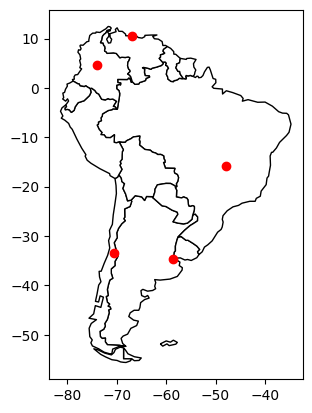

In [12]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres')) #Pillamos un fondo
ax = world[world.continent == 'South America'].plot(color='white', edgecolor='black')
gdf.plot(ax=ax, color='red')
plt.show()

### From WKT format
===============
Here, we consider a ``DataFrame`` having coordinates in WKT format.

In [13]:
df = pd.DataFrame(
    {'City': ['Buenos Aires', 'Brasilia', 'Santiago', 'Bogota', 'Caracas'],
     'Country': ['Argentina', 'Brazil', 'Chile', 'Colombia', 'Venezuela'],
     'Coordinates': ['POINT(-58.66 -34.58)', 'POINT(-47.91 -15.78)',
                     'POINT(-70.66 -33.45)', 'POINT(-74.08 4.60)',
                     'POINT(-66.86 10.48)']})

In [14]:
# We use ``shapely.wkt`` sub-module to parse wkt format:
from shapely import wkt

df['Coordinates'] = df['Coordinates'].apply(wkt.loads)

In [15]:
#  The ``GeoDataFrame`` is constructed as follows :

gdf = geopandas.GeoDataFrame(df, geometry='Coordinates')

print(gdf.head())

           City    Country                  Coordinates
0  Buenos Aires  Argentina  POINT (-58.66000 -34.58000)
1      Brasilia     Brazil  POINT (-47.91000 -15.78000)
2      Santiago      Chile  POINT (-70.66000 -33.45000)
3        Bogota   Colombia    POINT (-74.08000 4.60000)
4       Caracas  Venezuela   POINT (-66.86000 10.48000)


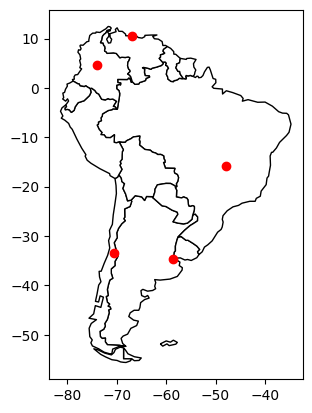

In [16]:
# Again, we can plot our ``GeoDataFrame``.
ax = world[world.continent == 'South America'].plot(
    color='white', edgecolor='black')

gdf.plot(ax=ax, color='red')
plt.show()

***
### Using GDAL
First, some variables
***

In [97]:
projwin='-360000,4070000,-350000,4070000, [EPSG:3857]'

entrada1="WCS:https://beta-karttakuva.maanmittauslaitos.fi/wcs/service/ows?version=2.0.1&coverage=ortokuva__ortokuva"
entrada2="WCS:http://www.juntadeandalucia.es/medioambiente/mapwms/REDIAM_WCS_mdt?version=1.0.0&identifier=Modelo%20Digital%20de%20Elevaciones%20(MDE)%20de%20Andalucia%2010%20m"
entrada3="d:/onedrive/proyectos/acc/ignore/demzonamalaga.gpkg"

In [98]:
dataset=gdal.Open(entrada3)
# dataset.SetProjection ("EPSG:25830")
print("Driver: {}/{}".format(dataset.GetDriver().ShortName,
                            dataset.GetDriver().LongName))
print("Size is {} x {} x {}".format(dataset.RasterXSize,
                                    dataset.RasterYSize,
                                    dataset.RasterCount))
print("Projection is {}".format(dataset.GetProjection()))
geotransform = dataset.GetGeoTransform()
if geotransform:
    print("Origin = ({}, {})".format(geotransform[0], geotransform[3]))
    print("Pixel Size = ({}, {})".format(geotransform[1], geotransform[5]))



Driver: GPKG/GeoPackage
Size is 3553 x 3507 x 1
Projection is PROJCS["ETRS89 / UTM zone 30N",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","25830"]]
Origin = (356968.6586, 4093051.8894)
Pixel Size = (10.0002113988179, -9.9987794411178)


In [99]:
band = dataset.GetRasterBand(1)

min = band.GetMinimum()
max = band.GetMaximum()
if not min or not max:
    (min,max) = band.ComputeRasterMinMax(True)
print("Min={:.3f}, Max={:.3f}".format(min,max))

if band.GetOverviewCount() > 0:
    print("Band has {} overviews".format(band.GetOverviewCount()))

if band.GetRasterColorTable():
    print("Band has a color table with {} entries".format(band.GetRasterColorTable().GetCount()))

Min=0.000, Max=1374.074


In [108]:
gdal.UseExceptions()
options_list ="-ot Byte -of JPEG" 
gdal.Translate('d:/1.jpg',dataset,bandList=[1],options=options_list);